In [5]:
import numpy as np
import pandas as pd
import eleanor
import lightkurve
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

Load in a dataframe of all TOIs from exofop.

In [6]:
df = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# save relevant columns as np arrays
IDs = df["TIC ID"].values
TOIs = df["TOI"].values
ras = df["RA"].values
decs = df["Dec"].values
epochs = df["Epoch (BJD)"].values - 2457000
periods = df["Period (days)"].values
sectors = df["Sectors"].values

# adjust sectors array to only include the first sector of each TOI
first_sectors = np.zeros(sectors.shape[0], dtype="U2")
for i in range(first_sectors.shape[0]):
    first_sectors[i] = sectors[i].split(",")[0]

Select the TOI you want to look at.

101.01


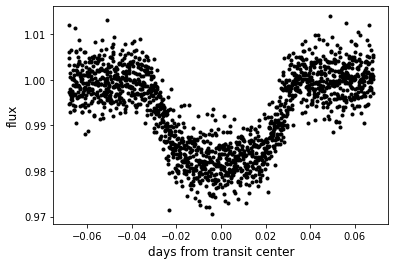

In [51]:
this_toi = '101.01'

hf_time = h5py.File('2min_SAP_times.h5', 'r')
hf_flux = h5py.File('2min_SAP_fluxes.h5', 'r')
keys = np.array(list(hf_time.keys()))

time_2min = np.array(hf_time.get(this_toi))
flux_2min = np.array(hf_flux.get(this_toi))
idx = np.argwhere(np.array(TOIs,  dtype=str) == this_toi)[0,0] 
ID = IDs[idx]
epoch = epochs[idx]
period = periods[idx]
sector = first_sectors[idx]

print(this_toi)
plt.plot(time_2min, flux_2min, 'k.')
plt.xlabel('days from transit center', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

hf_time.close()
hf_flux.close()

Use eleanor to pull the FFI data and inspect the raw light curve.

In [11]:
star = eleanor.Source(tic=str(ID), sector=int(sector), tc=True)
data = eleanor.TargetData(star, height=13, width=13, bkg_size=31)

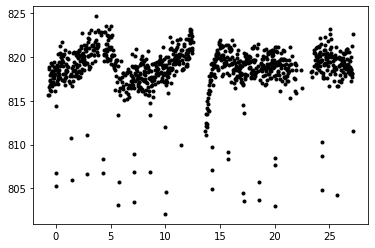

In [31]:
# restrict to data points without quality warning flags (these may be unreliable)
q = data.quality == 0
# subtract the transit epoch from time to center the transit at zero days
time = data.time[q] - epoch
flux = data.corr_flux[q]
# plot the light curve
plt.plot(time, flux, 'k.');

Instantiate a TessLightCurve object using lightkurve.

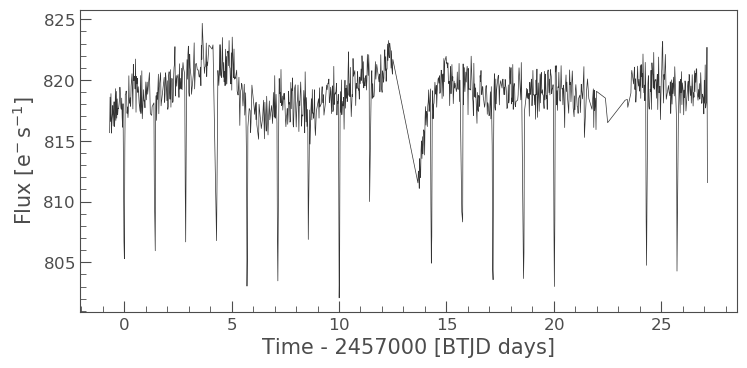

In [33]:
lc = lightkurve.TessLightCurve(time, flux)
lc.plot();

Flatten the light curve using the built-in .flatten() method. The argument "window_length" can be adjusted to meet the needs of your specific light curve. A common choice is 2 days, which corresponds to 96 data points for 30-minute cadence data (i.e., 2 points per hour * 24 hours per day * 2 days). Note that this could lead to issues if the orbital period of the planet is close to 2 days.

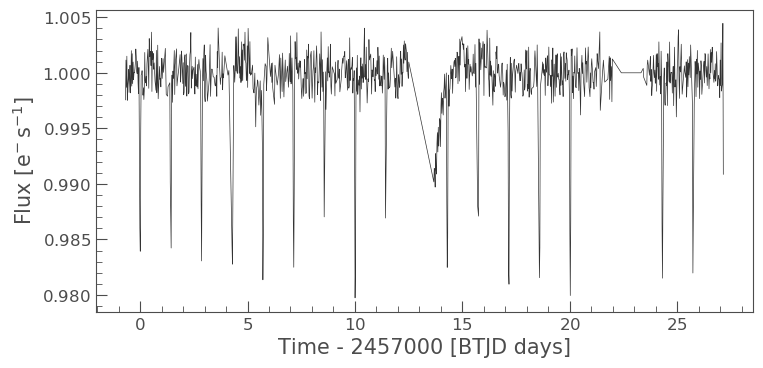

In [36]:
# window_length needs to be odd, so add 1
wlen = 96+1
lc_flat = lc.flatten(window_length=wlen)
lc_flat.plot();

Phase-fold the data to the orbital period to get the transit.

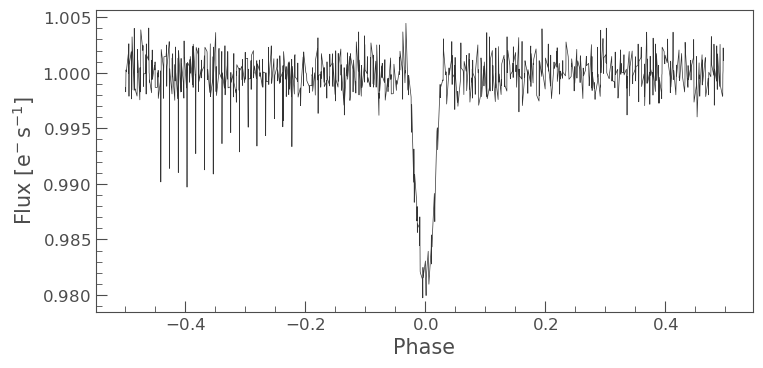

In [35]:
lc_folded = lc_flat.fold(period=period)
lc_folded.plot();

Compare the 2-min data and the 30-min data to see if they match.

In [48]:
time_30min = lc_folded.time*period
flux_30min = lc_folded.flux

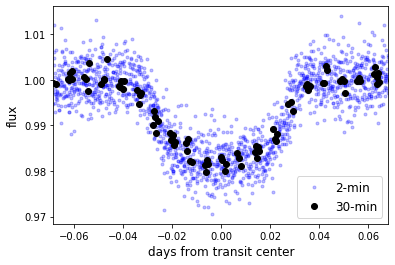

In [49]:
plt.plot(time_2min, flux_2min, 'b.', alpha=0.25, label='2-min')
plt.plot(time_30min, flux_30min, 'ko', label='30-min')
plt.xlim([time_2min.min(), time_2min.max()])
plt.xlabel('days from transit center', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.legend(loc=4, fontsize=12)
plt.show()